In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import time

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain
from exp_hp import get_hp

2024-08-15 12:03:31.367159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 12:03:37.934125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-15 12:03:45.550081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 74024 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [2]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)     
        grads.append(grad)
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)
    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

In [3]:
#----- SET UP & TRAIN NN -----
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain_increase'
hps2 = get_hp(EXP_NAME2)

GLOBAL_SEED = hps2['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

print('Validation Member: '+str(hps2['val_mems'][0]))
print('Testing Member: '+str(hps2['test_mems'][0]))
print('Lead: '+str(hps2['LEAD']))
print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

for i_trainmems in np.arange(0,1):
    print(i_trainmems)
    print('Training Members: '+str(hps2['train_mems'][i_trainmems]))

    _, _, X1test, _, _, Y1test,_ = split_retrain(trainmems = hps2['train_mems'][i_trainmems],
                                                  valmem = hps2['val_mems'][0],
                                                  testmem = hps2['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps2['LEAD'])

    nlat = X1test.shape[1]
    nlon = X1test.shape[2]
    
    for SEED in np.arange(0,10):
        IG_neg_heatmap = []
        IG_pos_heatmap = []
        print(SEED)
        cnn2fi_name = 'cnn2_'+EXP_NAME+'.'+str(i_trainmems)+'_seed'+str(SEED)+'.h5'
        model = tf.keras.models.load_model(base_dir+'CNNcheck/saved_models/'+cnn2fi_name)
        
        pred = model.predict(X1test)
        predconf = np.max(pred,axis=-1)
        predval  = np.argmax(pred,axis=-1)
    
        iconf = np.where(predconf >= np.percentile(predconf,q=80))
        icorr = np.where(predval[iconf] == Y1test[iconf])
        
        ineg = np.where(Y1test[iconf][icorr] == 0)
        ipos = np.where(Y1test[iconf][icorr] == 1)
        
        # print(len(ineg[0]))
        # print(len(ipos[0]))
        
        if len(ineg[0]) > 0:
            for neg_sample in X1test[iconf][icorr][ineg]:
                IG_negsample_heatmap = get_integrated_gradients(neg_sample.reshape((1,nlat,nlon)),top_pred_idx=0).numpy()[0]
                IG_neg_heatmap.append(IG_negsample_heatmap/np.max(np.abs(IG_negsample_heatmap)))
            
            np.save(base_dir+'CNNcheck/IG_data/IG_cnn2_60Eshift_'+EXP_NAME2+'.'+str(i_trainmems)+'_cnn1_'+EXP_NAME+'_negconf_seed'+str(SEED)+'.npy',
                    IG_neg_heatmap,
                    allow_pickle=True)
        
        if len(ipos[0]) > 0:
            for pos_sample in X1test[iconf][icorr][ipos]:
                IG_possample_heatmap = get_integrated_gradients(pos_sample.reshape((1,nlat,nlon)),top_pred_idx=1).numpy()[0]
                IG_pos_heatmap.append(IG_possample_heatmap/np.max(np.abs(IG_possample_heatmap)))
                
            np.save(base_dir+'CNNcheck/IG_data/IG_cnn2_60Eshift_'+EXP_NAME2+'.'+str(i_trainmems)+'_cnn1_'+EXP_NAME+'_posconf_seed'+str(SEED)+'.npy',
                    IG_pos_heatmap,
                    allow_pickle=True)

Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
0
Training Members: ['0201']
loading data & saving
made it!
0


2024-08-15 12:03:54.991362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 74024 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0
2024-08-15 12:03:56.220819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


  1/228 [..............................] - ETA: 3:22

2024-08-15 12:03:56.550318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


228/228 [==============================] - 1s 2ms/step
1
228/228 [==============================] - 0s 2ms/step
2
228/228 [==============================] - 0s 2ms/step
3
228/228 [==============================] - 0s 1ms/step
4
228/228 [==============================] - 0s 2ms/step
5
228/228 [==============================] - 0s 1ms/step
6
228/228 [==============================] - 0s 1ms/step
7
228/228 [==============================] - 0s 1ms/step
8
228/228 [==============================] - 0s 1ms/step
9
228/228 [==============================] - 0s 1ms/step


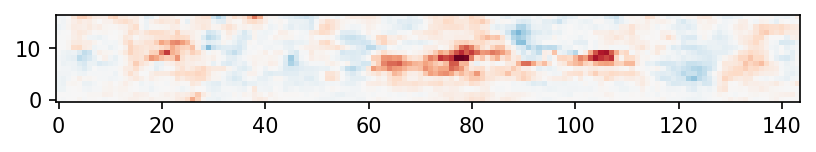

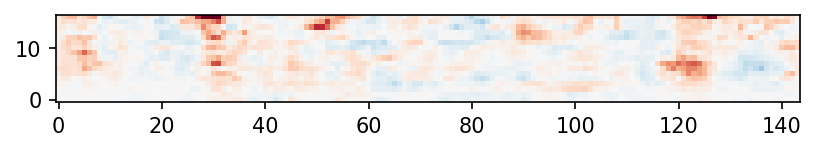

In [4]:
# EXP3.1.0
IG_neg_heatmap_mean = np.mean(IG_neg_heatmap,0)
IG_pos_heatmap_mean = np.mean(IG_pos_heatmap,0)

plt.imshow(IG_neg_heatmap_mean,origin='lower',cmap='RdBu_r',vmin=-.1,vmax=.1)
plt.show()
plt.imshow(IG_pos_heatmap_mean,origin='lower',cmap='RdBu_r',vmin=-.1,vmax=.1)
plt.show()

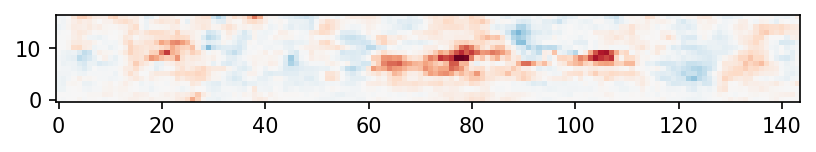

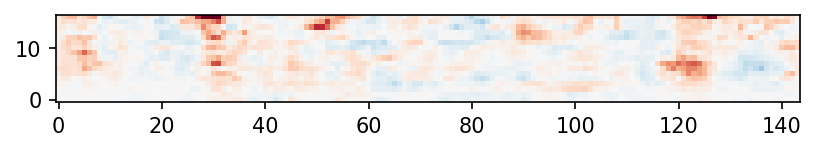

In [5]:
# EXP4.1.0
IG_neg_heatmap_mean = np.mean(IG_neg_heatmap,0)
IG_pos_heatmap_mean = np.mean(IG_pos_heatmap,0)

plt.imshow(IG_neg_heatmap_mean,origin='lower',cmap='RdBu_r',vmin=-.1,vmax=.1)
plt.show()
plt.imshow(IG_pos_heatmap_mean,origin='lower',cmap='RdBu_r',vmin=-.1,vmax=.1)
plt.show()